# Elastic Net Regression for Rogue Wave Prediction

***Model motivation and approach***

In this notebook, we explore rogue wave prediction using a linear regression model with Elastic Net regularization. Elastic Net combines the benefits of both Lasso (L1) and Ridge (L2) penalties, making it well suited for datasets where input features exhibit strong correlations.  
- **L1 regularization** promotes sparsity by shrinking some coefficients to zero, effectively performing feature selection.  
- **L2 regularization** stabilizes coefficient estimates and mitigates multicollinearity.  

This hybrid behaviour allows the model to balance interpretability, robustness, and generalization.

We begin with a linear model because it provides a transparent mapping between inputs and predictions. Unlike nonlinear architectures, linear regression allows direct interpretation of how each feature influences the Abnormality Index (AbnI), facilitating physical insight into wave–environment relationships.

***Data preprocessing***

Before fitting the model, all input variables are standardized using `StandardScaler`. Because Elastic Net penalizes absolute coefficient magnitudes, proper scaling ensures that no feature dominates solely due to its numerical range. 

***Model Training***

Hyperparameter optimization is performed using stratified k-fold cross-validation to maintain proportional representation of rare rogue-wave events in all folds. This improves stability and comparability across validation splits.

The following hyperparameters are optimized:

- **alpha** = [0.0001, 0.001, 0.01, 0.1, 1, 10]  
  Controls overall regularization strength; the logarithmic range enables exploration of both weak and strong shrinkage regimes.

- **l1_ratio** = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]  
  Governs the balance between L1 (sparsity) and L2 (stability). Testing the full spectrum from 0.1 to 1.0 evaluates models from dense to fully sparse.

- **max_iter** = 5000  
  Ensures convergence during coordinate descent.

- **tol** = [1e-3, 1e-4]  
  Convergence criteria tested for numerical reliability.

- **selection** = ['cyclic', 'random']  
  Specifies the update rule for coordinate descent. 'cyclic' iterates through features in a fixed order, while 'random' selects features randomly. 

***Model Evaluation***

To assess predictive performance, we compute:

- **MSE** — sensitive to large errors  
- **MAE** — robust average deviation  
- **R² score** — explained variance  
- **Spearman correlation** — preserves rank information even when relationships are not strictly linear  

Together, these metrics provide a comprehensive view of model accuracy and stability.

***Model Interpretation***

Interpretability is examined through two complementary approaches:

1. **Coefficient inspection**  
   Reveals global feature importance by examining the magnitude and sign of learned coefficients.

2. **SHAP analysis**  
   We compute SHAP values using the `LinearExplainer` with `feature_perturbation="correlation_dependent"`, which accounts for statistical dependencies between correlated predictors, which is necessary for realistic interpretation in linear models with multicollinearity. Training-set SHAP values reflect learned dependencies, while test-set values show how well these dependencies generalize. Comparing both sets helps identify overfitting and highlights which features consistently drive predictions across unseen data.

***Conclusion***

The Elastic Net regression model is unable to capture meaningful predictive structure in the data. Performance metrics remain near baseline levels, and nearly all feature coefficients shrink toward zero, leaving the model dominated by the intercept. These results indicate that linear relationships are insufficient for explaining rogue wave abnormality and that nonlinear interactions likely play a dominant role in rogue wave formation.


In [1]:
%load_ext autoreload
%autoreload 2

**Imports**

In [2]:
import sys
import shap
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

sys.path.append('./')
sys.path.append('../scripts/')
import utils

import warnings
warnings.filterwarnings("ignore")

To reproduce the trained model results and evaluate the SHAP values, please download the precomputed model outputs using the code snippet below. The archive contains all necessary files, including the trained model and SHAP results.

The downloaded archive contains the following files:

* `model_and_data.pkl` – trained model and associated dataset
* `cv_results.csv` – cross-validation results
* `train_lm.out` – training output log
* `train_shap.pkl` – SHAP values for the training set
* `test_shap.pkl` – SHAP values for the test set

These files allow you to load the trained model directly and reproduce all evaluation and SHAP analyses without retraining.

In [ ]:
# dir_output = "../results/"
# os.makedirs(dir_output, exist_ok=True)

# download zip file from link below. 
# url = "https://github.com/HelmholtzAI-Consultants-Munich/rogue_wave_prediction/releases/latest/download/lm.zip"
# with open(f"{dir_output}/lm.zip", "wb") as f:
#     f.write(requests.get(url).content)

# with zipfile.ZipFile(f"{dir_output}/lm.zip", 'r') as zip_ref:
#     zip_ref.extractall(dir_output)

In [3]:
# we run the model training on a compute cluster 
# we load the model and cross-validation results here
file_cv_results = "../results/lm/cv_results.csv"
file_data_model = "../results/lm/model_and_data.pkl"
file_shap_train = "../results/lm/train_shap.pkl"
file_shap_test = "../results/lm/test_shap.pkl"

Model training was conducted on a high-performance computing (HPC) cluster equipped with an Intel Xeon 6248R CPU (96 cores and 192 threads) and 744 GB of RAM. The Elastic Net model was trained using 50 of the available CPU cores and 100 GB of memory. Hyperparameter optimization was performed via grid search with five-fold cross-validation over 144 candidate parameter combinations, yielding a total of 720 fitted models. The complete cross-validation procedure required 3 min with one fit taking on average 0.3 sec.

For reproducibility use the following scripts:

- model training python script: *scripts/train_model.py*
- HPC configuration for linear model: *scripts/train_lm.sh*

**Model Evaluation**

In [4]:
model, X_train_transformed, y_train, y_train_cat, X_test_transformed, y_test, y_test_cat = utils.load_data_and_model(file_data_model, output=False)
cv_results = pd.read_csv(file_cv_results, index_col=0)  
cv_results

,alpha,l1_ratio,max_iter,selection,tol,score
0,0.0001,0.1,5000,cyclic,0.0001,0.062778
1,0.0001,0.1,5000,cyclic,0.0010,0.062778
2,0.0001,0.1,5000,random,0.0001,0.062778
3,0.0001,0.1,5000,random,0.0010,0.062778
4,0.0001,0.3,5000,cyclic,0.0001,0.062772
...,...,...,...,...,...,...
139,10.0000,0.9,5000,random,0.0001,-0.000002
140,10.0000,1.0,5000,cyclic,0.0010,-0.000002
141,10.0000,1.0,5000,cyclic,0.0001,-0.000002
142,10.0000,1.0,5000,random,0.0010,-0.000002


Evaluate on Training Set


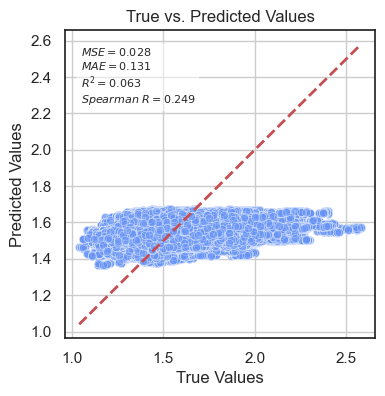

Evaluate on Test Set


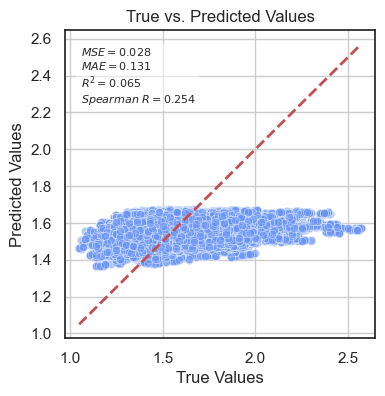

In [5]:
_, _, _, _, _, _ = utils.evaluate_best_regressor(model, X_train_transformed, y_train, dataset="Training", plot=True)
_, _, _, _, _, _ = utils.evaluate_best_regressor(model, X_test_transformed, y_test, dataset="Test", plot=True)

**Model Interpretation**

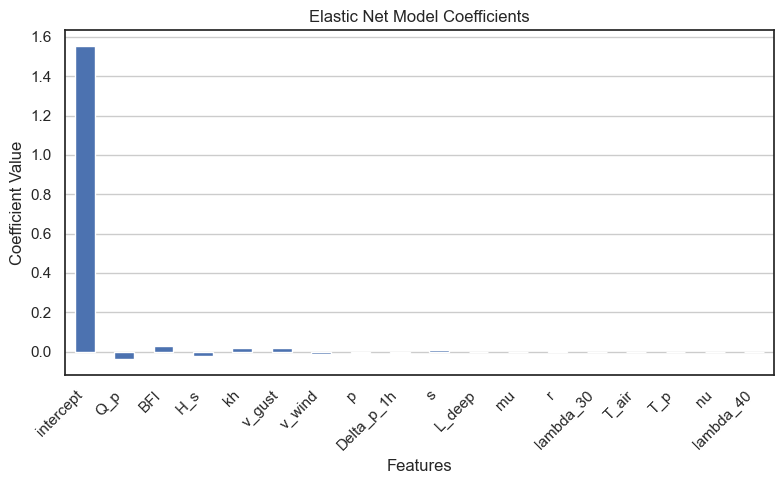

In [6]:
# Feature importance based on model coefficients
feature_importance = pd.DataFrame(model.coef_, index=X_train_transformed.columns, columns=["Coefficient"])
feature_importance.loc["intercept", "Coefficient"] = model.intercept_
feature_importance = feature_importance.sort_values(by="Coefficient", ascending=False, key=abs)

# Plotting
plt.figure(figsize=(8, 5))
feature_importance["Coefficient"].plot(kind='bar')
plt.title("Elastic Net Model Coefficients")
plt.ylabel("Coefficient Value")
plt.xlabel("Features")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

Interpretation on Training Set

In [7]:
file_shap = f"../results/lm/train_shap.pkl"

# Load and unpack the shap values
with open(file_shap, "rb") as handle:
    explanation_train = pickle.load(handle)

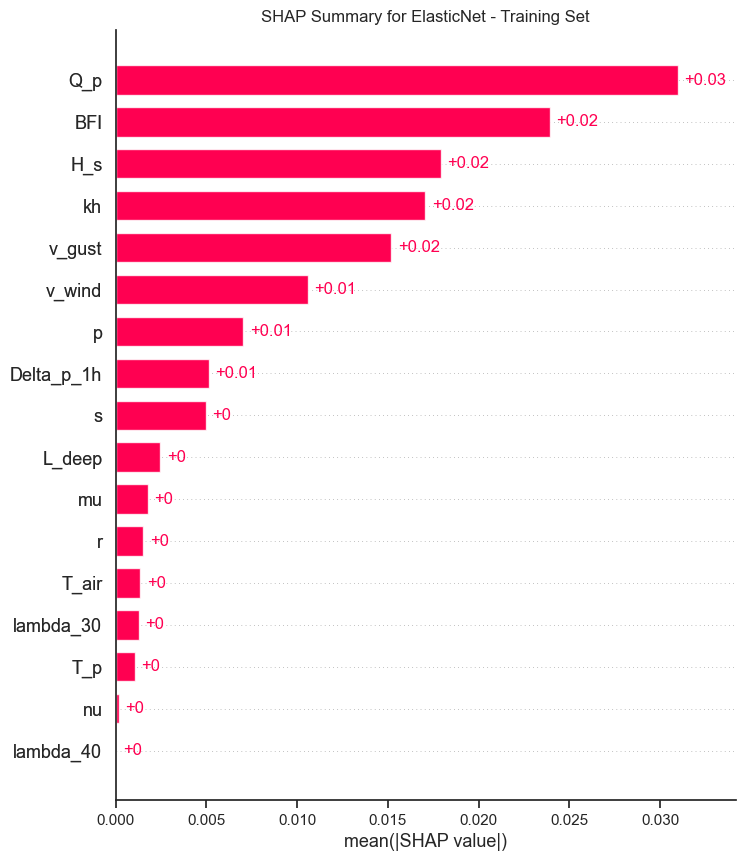

In [8]:
shap.plots.bar(explanation_train, max_display=17, show=False)
plt.title("SHAP Summary for ElasticNet - Training Set")
plt.show()

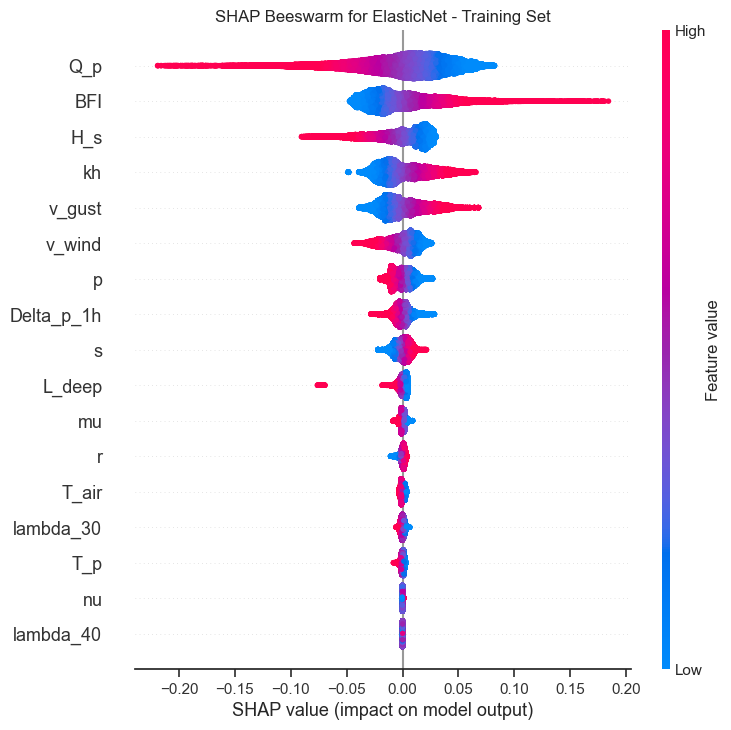

In [9]:
shap.plots.beeswarm(explanation_train, max_display=17, show=False)
plt.title("SHAP Beeswarm for ElasticNet - Training Set")
plt.show()

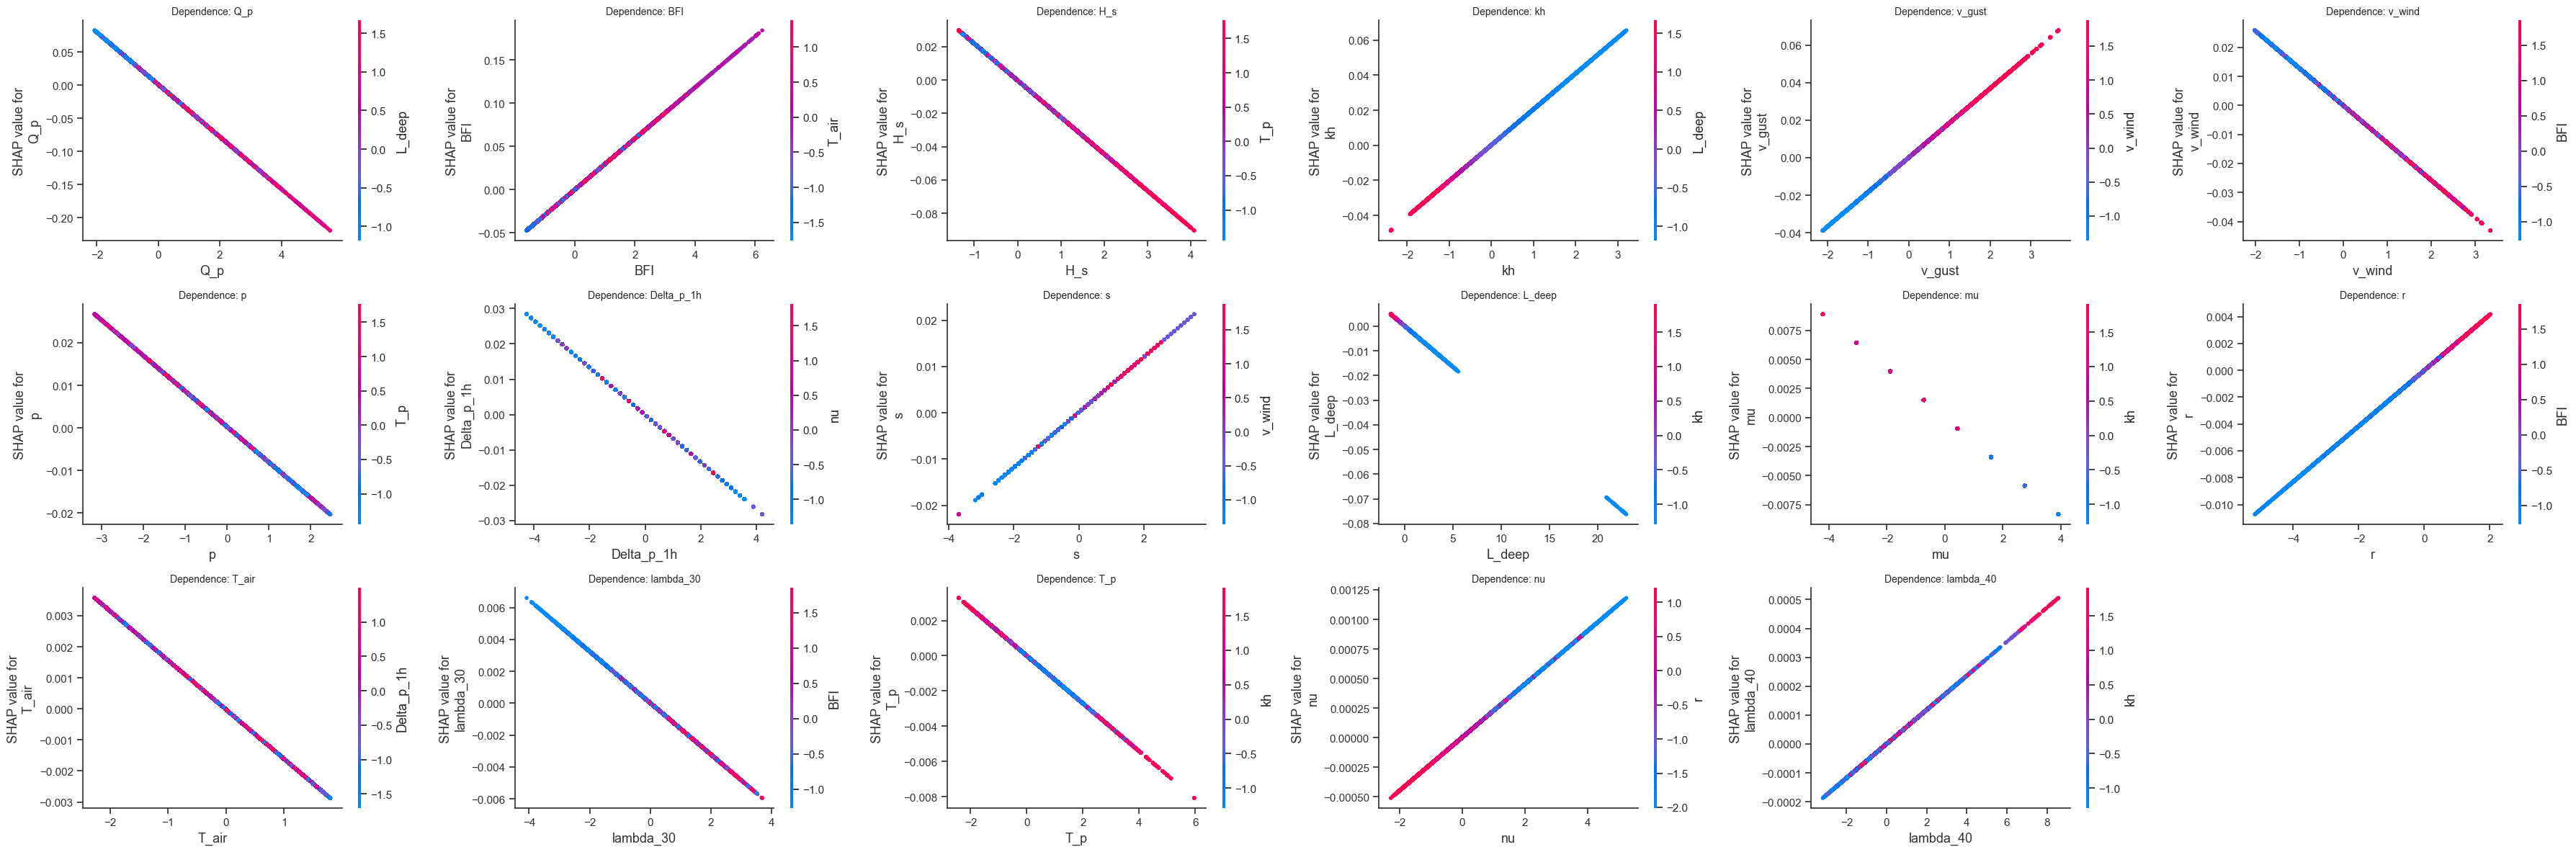

In [10]:
utils.plot_shap_dependence(explanation_train)

In [11]:
file_shap = f"../results/lm/test_shap.pkl"

# Load and unpack the shap values
with open(file_shap, "rb") as handle:
    explanation_test = pickle.load(handle)

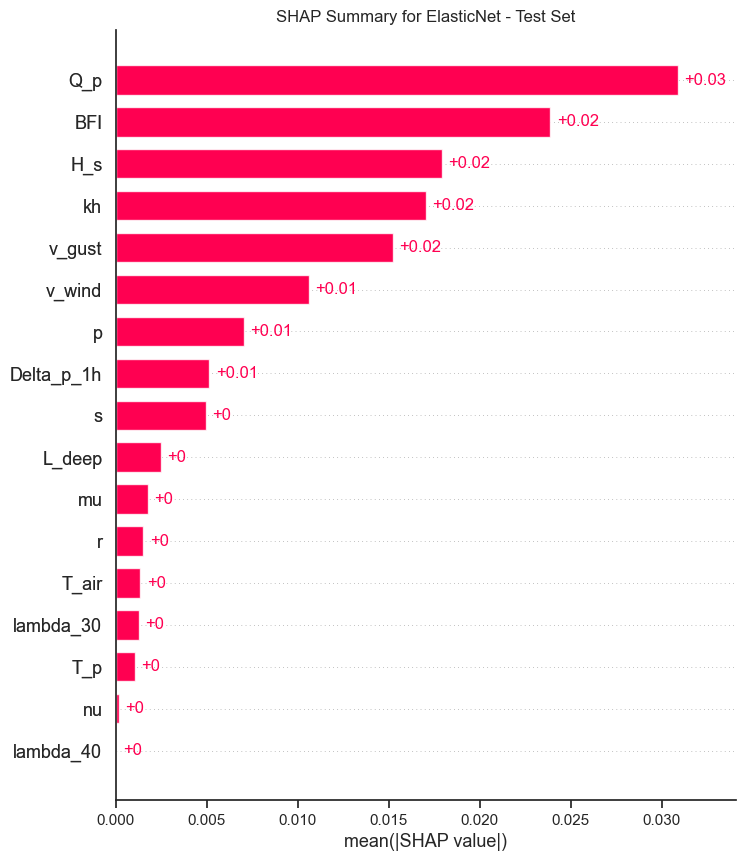

In [12]:
shap.plots.bar(explanation_test, max_display=17, show=False)
plt.title("SHAP Summary for ElasticNet - Test Set")
plt.show()

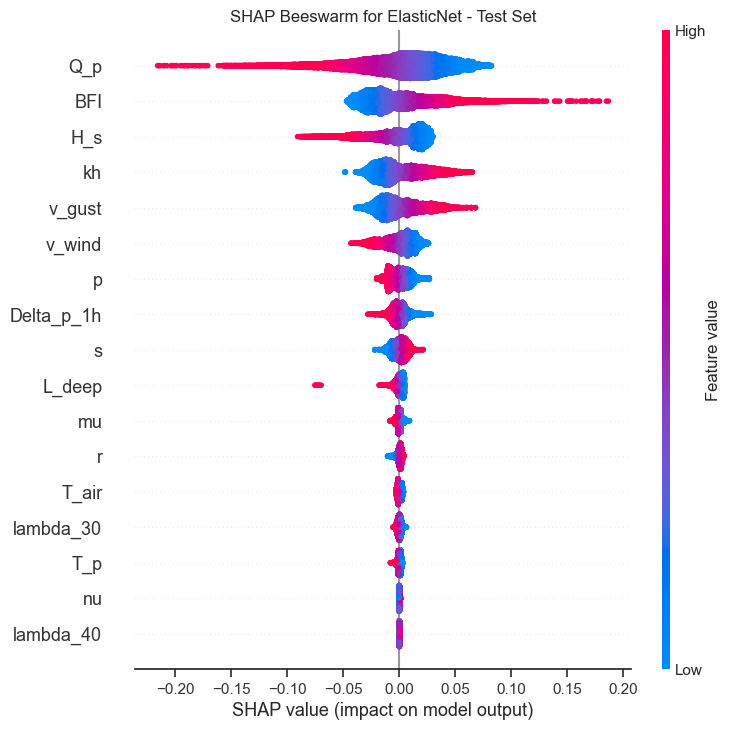

In [13]:
shap.plots.beeswarm(explanation_test, max_display=17, show=False)
plt.title("SHAP Beeswarm for ElasticNet - Test Set")
plt.show()

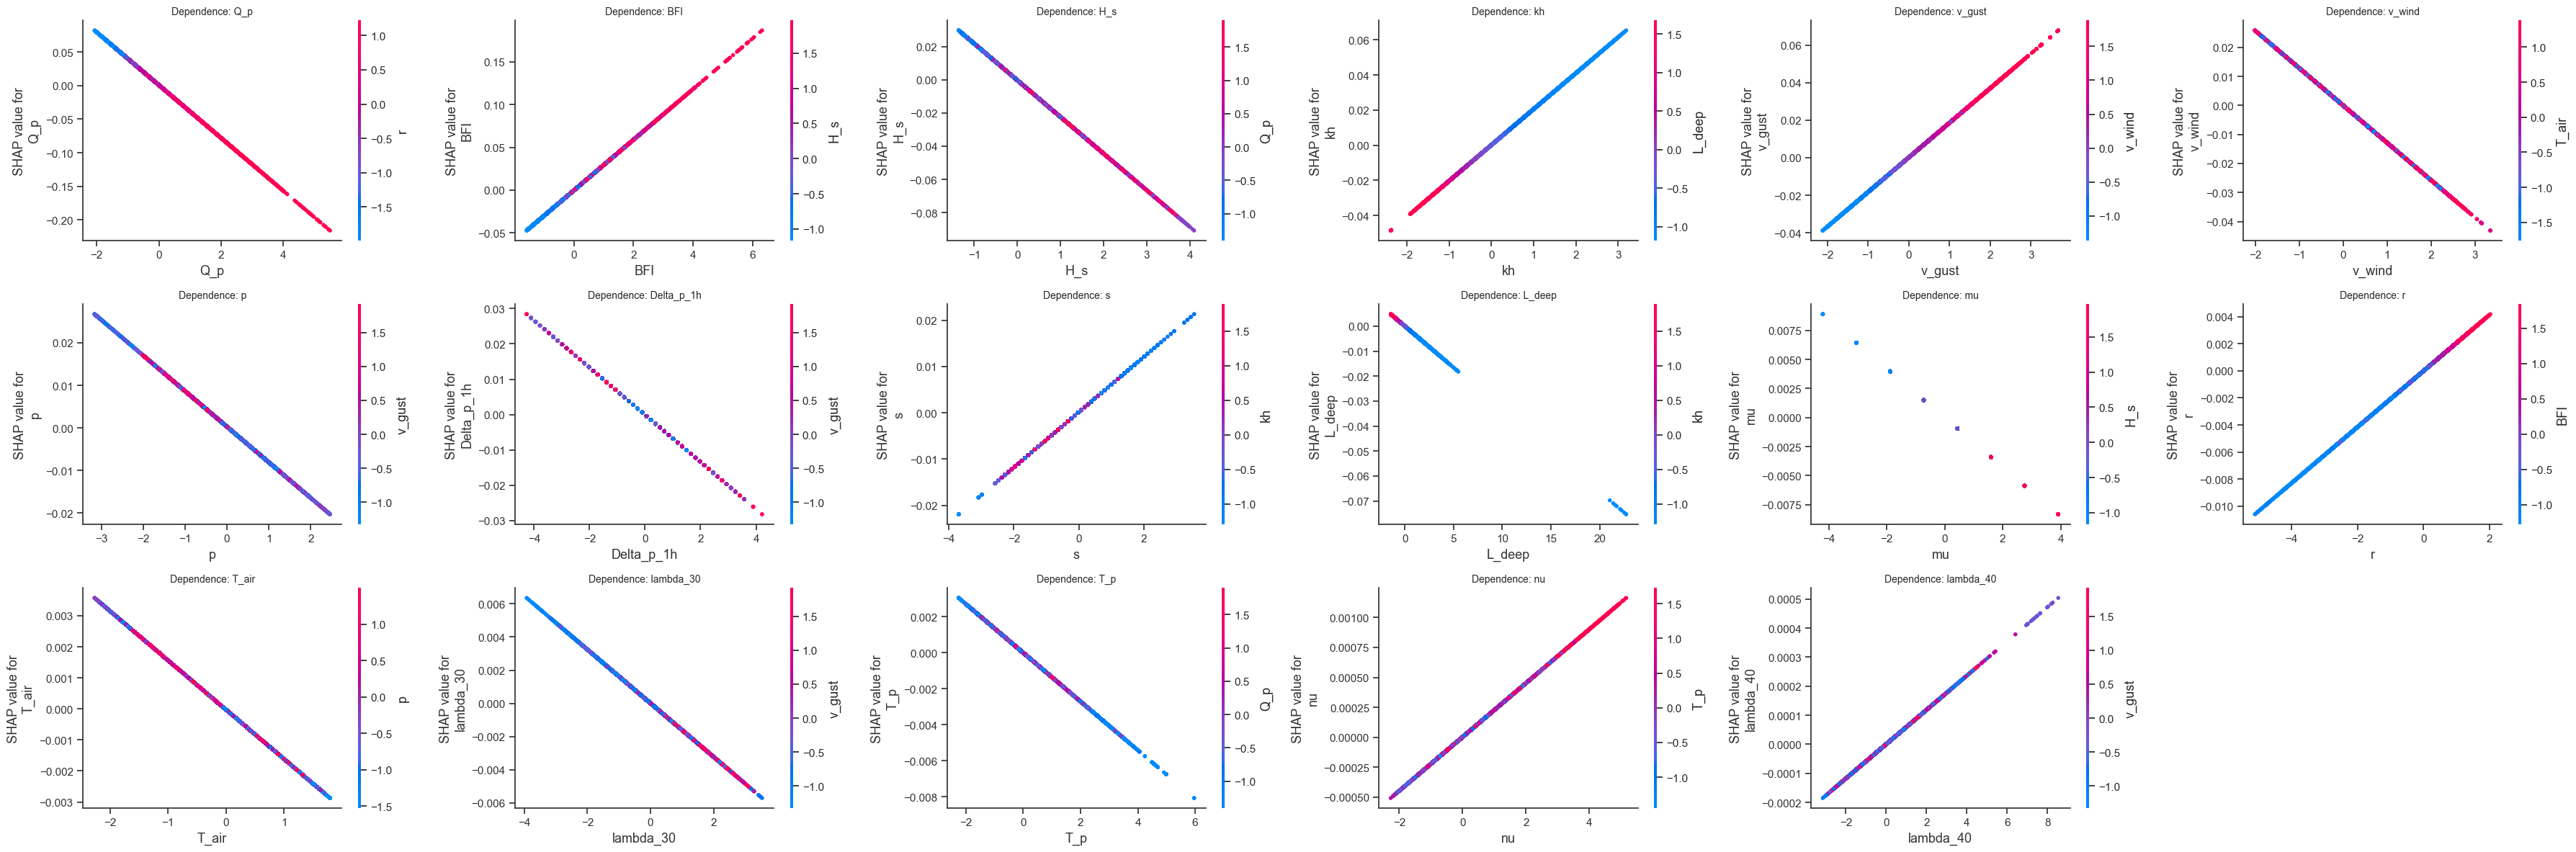

In [14]:
utils.plot_shap_dependence(explanation_test)